In [18]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

In [ ]:
sequence_length = 4
batch_size = 1
input_dim = 512
d_model = 512
x = torch.randn( (batch_size, sequence_length, input_dim) )

In [ ]:
x.size()

In [ ]:
qkv_layer = nn.Linear(input_dim , 3 * d_model)

In [ ]:
qkv = qkv_layer(x)

In [ ]:
qkv.shape


In [ ]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins=200, min=-3, max=3)
x_val = np.arange(-1, 1, 0.01) * 3
plt.bar(x_val, y_val, align='center', color=['forestgreen'])
plt.title('qkv distribution')

# ***Multi Head Attention***

Multi-head attention just repeats this multiple times in parallel with different "heads" and then combines them.

In [2]:
"""
torch, nn → for building the model
F → for functions like softmax
math → for square root in attention scaling
numpy and matplotlib (used earlier for histogram visualization)
"""

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [4]:
"""
x has shape [1, 4, 512]
1 → number of sequences in the batch
4 → tokens per sequence
512 → each token’s embedding dimension
✅ Shape: [batch_size, sequence_length, input_dim]
"""

sequence_length = 4
batch_size = 1
input_dim = 512
d_model = 512
x = torch.randn((batch_size, sequence_length, input_dim))

In [5]:
x.size()

torch.Size([1, 4, 512])

In [7]:
"""
You pass each 512-dim input vector through a linear layer to produce Q, K, and V together.
The output has 3 × 512 = 1536 features per token.
✅ Shape: [1, 4, 1536]
"""

qkv_layer = nn.Linear(input_dim , 3 * d_model)
qkv = qkv_layer(x)

In [8]:
qkv.shape

torch.Size([1, 4, 1536])

In [10]:
"""
You reshape [1, 4, 1536] → [1, 4, 8, 192]
(because 3 * head_dim = 3 * 64 = 192)
This separates the features into 8 attention heads.
✅ Shape: [batch, seq_len, num_heads, 3*head_dim]
"""

num_heads = 8
head_dim = d_model // num_heads  # 512 / 8 = 64
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3 * head_dim)

In [11]:
qkv.shape

torch.Size([1, 4, 8, 192])

In [13]:
"""
You move num_heads to the 2nd dimension to make processing easier per head.
✅ Shape: [1, 8, 4, 192]
→ 1 batch, 8 heads, 4 tokens, 192 dims (for Q, K, V combined)
"""

qkv = qkv.permute(0, 2, 1, 3) # [batch_size, num_heads, sequence_length, 3*head_dim]
qkv.shape

torch.Size([1, 4, 8, 192])

In [16]:
"""
You split the last dimension (192) into three equal parts:
q, k, v each get 64 dims.
✅ Each shape: [1, 8, 4, 64]
So now, for each head, you have:
4 queries (one per token)
4 keys
4 values
"""

q, k, v = qkv.chunk(3, dim=-1)
q.shape, k.shape, v.shape

(torch.Size([1, 4, 8, 64]),
 torch.Size([1, 4, 8, 64]),
 torch.Size([1, 4, 8, 64]))

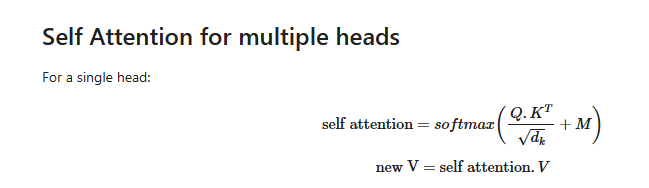

In [22]:
"""
Multiply Q × Kᵀ for similarity.
Divide by √dₖ = √64 = 8 → prevents large values that hurt softmax.
✅ Shape: [1, 8, 4, 4]
→ For each head: 4×4 matrix showing how much each token attends to every other token.
"""

d_k = q.size()[-1]
scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
scaled.shape

torch.Size([1, 4, 8, 8])

In [23]:
k.T.shape

torch.Size([64, 8, 4, 1])

In [24]:
mask = torch.full(scaled.size(), float('-inf'))
mask = torch.triu(mask, diagonal=1)
scaled += mask

In [25]:
scaled[0][0]

tensor([[ 0.2894,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
        [-0.1887,  0.1162,    -inf,    -inf,    -inf,    -inf,    -inf,    -inf],
        [ 0.2285,  0.5113,  0.0560,    -inf,    -inf,    -inf,    -inf,    -inf],
        [-0.1282, -0.5196,  0.3257, -0.5121,    -inf,    -inf,    -inf,    -inf],
        [ 0.0940, -0.0195,  0.2523, -0.1912,  0.2127,    -inf,    -inf,    -inf],
        [ 0.0731,  0.3744, -0.2605,  0.2175,  0.0957, -0.2880,    -inf,    -inf],
        [ 0.1839,  0.4767,  0.2994, -0.0791,  0.1000, -0.3882,  0.5433,    -inf],
        [-0.4190,  0.3728,  0.1562,  0.2841, -0.5376, -0.0579,  0.1989, -0.0129]],
       grad_fn=<SelectBackward0>)

In [27]:
"""
Converts scores into probabilities (each row sums to 1).
✅ Shape: [1, 8, 4, 4]
"""

attention = F.softmax(scaled, dim=-1)

In [34]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4244, 0.5756, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3156, 0.4188, 0.2656, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2543, 0.1720, 0.4004, 0.1733, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2023, 0.1806, 0.2370, 0.1521, 0.2278, 0.0000, 0.0000, 0.0000],
        [0.1683, 0.2274, 0.1205, 0.1944, 0.1721, 0.1173, 0.0000, 0.0000],
        [0.1399, 0.1875, 0.1570, 0.1075, 0.1286, 0.0790, 0.2004, 0.0000],
        [0.0788, 0.1740, 0.1401, 0.1593, 0.0700, 0.1131, 0.1462, 0.1183]],
       grad_fn=<SelectBackward0>)

In [28]:
"""
This multiplies each v vector by its corresponding attention weight → “contextualizes” each token.
✅ Shape: [1, 8, 4, 64]
"""
values = torch.matmul(attention, v)

In [30]:
"""
This wraps the whole attention logic into one function for reuse.
"""

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [32]:
"""
Inside the constructor:
You define parameters
Create two linear layers:
qkv_layer → generates Q, K, V
linear_layer → merges heads at the end
"""

class MultiheadAttention(nn.Module):
    def __init__(self, input_dim, d_model, num_heads):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(input_dim, 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)

In [33]:
"""
Step	    Operation     	      Input Shape	      Output Shape
1	        Linear projection	    [30,5,1024]	      [30,5,1536]
2	        Reshape	              [30,5,1536]	      [30,5,8,192]
3	        Permute	              [30,5,8,192]	    [30,8,5,192]
4	        Split Q,K,V	          [30,8,5,192]	    [30,8,5,64] each
5	        Attention             [30,8,5,64]	      [30,8,5,64]
6	        Merge heads	          [30,8,5,64]	      [30,5,512]
7	        Final linear	        [30,5,512]	      [30,5,512]
"""


def forward(self, x, mask=None):
    batch_size, sequence_length, input_dim = x.size()
    qkv = self.qkv_layer(x)
    qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
    qkv = qkv.permute(0, 2, 1, 3)
    q, k, v = qkv.chunk(3, dim=-1)
    values, attention = scaled_dot_product(q, k, v, mask)
    values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
    out = self.linear_layer(values)
    return out

In [40]:
# FINAL CLASS

import torch
import torch.nn as nn
import math

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, d_model, num_heads):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(input_dim , 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        batch_size, sequence_length, input_dim = x.size()
        print(f"x.size(): {x.size()}")
        qkv = self.qkv_layer(x)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.permute(0, 2, 1, 3)
        print(f"qkv.size(): {qkv.size()}")
        q, k, v = qkv.chunk(3, dim=-1)
        print(f"q size: {q.size()}, k size: {k.size()}, v size: {v.size()}, ")
        values, attention = scaled_dot_product(q, k, v, mask)
        print(f"values.size(): {values.size()}, attention.size:{ attention.size()} ")
        values = values.reshape(batch_size, sequence_length, self.num_heads * self.head_dim)
        print(f"values.size(): {values.size()}")
        out = self.linear_layer(values)
        print(f"out.size(): {out.size()}")
        return out

In [41]:
input_dim = 1024
d_model = 512
num_heads = 8

batch_size = 30
sequence_length = 5
x = torch.randn( (batch_size, sequence_length, input_dim) )

model = MultiheadAttention(input_dim, d_model, num_heads)
out = model.forward(x)

x.size(): torch.Size([30, 5, 1024])
qkv.size(): torch.Size([30, 5, 1536])
qkv.size(): torch.Size([30, 5, 8, 192])
qkv.size(): torch.Size([30, 8, 5, 192])
q size: torch.Size([30, 8, 5, 64]), k size: torch.Size([30, 8, 5, 64]), v size: torch.Size([30, 8, 5, 64]), 
values.size(): torch.Size([30, 8, 5, 64]), attention.size:torch.Size([30, 8, 5, 5]) 
values.size(): torch.Size([30, 5, 512])
out.size(): torch.Size([30, 5, 512])
